In [1]:
# -------------------------------------------
# 1. 라이브러리 임포트 및 설정
# -------------------------------------------
import pandas as pd
import numpy as np
import pandas_ta as pta
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'AppleGothic' # Windows 사용자는 'Malgun Gothic'으로 변경
plt.rcParams['axes.unicode_minus'] = False
print("✅ 라이브러리 준비 완료")

2025-08-30 05:17:21.364972: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ 라이브러리 준비 완료


In [4]:
# -------------------------------------------
# 2. 각국 대표 지수 데이터 수집 및 기술적 지표 생성
# -------------------------------------------
indices_tickers = {
    # 아시아
    'KOSPI': 'KS11',
    'Nikkei 225': 'N225',
    'Shanghai': 'SSEC',
    'Hang Seng': 'HSI',
    'Taiwan': '^TWII',
    # 북미
    'S&P 500': 'US500',
    'Dow Jones': 'DJI',
    'NASDAQ': 'IXIC',
    'S&P/TSX': '^GSPTSE', # 캐나다
    # 유럽
    'FTSE 100': 'FTSE', # 영국
    'DAX': 'GDAXI', # 독일
    'CAC 40': 'FCHI', # 프랑스
    'EURO STOXX 50': '^STOXX50E' # 유로존
}

start_date = '2022-01-01'
end_date = '2025-08-30'

print(f"📈 총 {len(indices_tickers)}개 국가 지수의 데이터를 수집하고 기술적 지표를 생성합니다...")

index_dict = {}
for name, ticker in indices_tickers.items():
    try:
        df = fdr.DataReader(ticker, start_date, end_date)
        df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
        
        if df.empty: continue
        if 'volume' not in df.columns or df['volume'].isnull().all() or (df['volume'] == 0).all():
            df['volume'] = 0
        
        df.ta.rsi(append=True)
        df.ta.adx(append=True)
        df.ta.ema(length=14, append=True)
        bbands = pta.bbands(df['close'], length=20, append=False);
        if bbands is not None and not bbands.empty: df = pd.concat([df, bbands], axis=1)
        macd = pta.macd(df['close']);
        if macd is not None and not macd.empty: df = pd.concat([df, macd], axis=1)

        df.dropna(axis=0, how='any', inplace=True)
        if df.empty: continue
        
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df)
        df = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)
            
        index_dict[name] = df
        print(f"- {name} ({ticker}) 데이터 처리 완료")
    except Exception as e:
        print(f"- {name} ({ticker}) 처리 중 오류 발생: {e}")

if index_dict:
    min_len = min(len(df) for df in index_dict.values())
    trimmed_index_dict = {name: df.tail(min_len) for name, df in index_dict.items()}
    

    if trimmed_index_dict:
        common_columns = list(set.intersection(*(set(df.columns) for df in trimmed_index_dict.values())))
        standardized_index_dict = {
            name: df[common_columns] for name, df in trimmed_index_dict.items()
        }
        trimmed_index_dict = standardized_index_dict
        
        print(f"\n✅ 모든 데이터 길이를 {min_len}으로, 컬럼 개수를 {len(common_columns)}개로 통일 완료")
else:
    print("\n⚠️ 처리할 데이터가 없습니다.")

📈 총 13개 국가 지수의 데이터를 수집하고 기술적 지표를 생성합니다...
- KOSPI (KS11) 데이터 처리 완료
- Nikkei 225 (N225) 데이터 처리 완료
- Shanghai (SSEC) 데이터 처리 완료
- Hang Seng (HSI) 데이터 처리 완료
- Taiwan (^TWII) 데이터 처리 완료
- S&P 500 (US500) 데이터 처리 완료
- Dow Jones (DJI) 데이터 처리 완료
- NASDAQ (IXIC) 데이터 처리 완료
- S&P/TSX (^GSPTSE) 데이터 처리 완료
- FTSE 100 (FTSE) 데이터 처리 완료
- DAX (GDAXI) 데이터 처리 완료
- CAC 40 (FCHI) 데이터 처리 완료
- EURO STOXX 50 (^STOXX50E) 데이터 처리 완료

✅ 모든 데이터 길이를 854으로, 컬럼 개수를 18개로 통일 완료


In [6]:
# -------------------------------------------
# 3. 딥러닝 오토인코더 모델 정의
# -------------------------------------------
if 'trimmed_index_dict' in locals() and trimmed_index_dict:
    indices = list(trimmed_index_dict.keys())
    n_timesteps = min_len
    n_features = trimmed_index_dict[indices[0]].shape[1]
    n_indices = len(indices)
    x_data = np.array([df.values for df in trimmed_index_dict.values()])
    x = x_data.reshape(n_indices, n_timesteps, n_features, 1).astype('float32')

    print(f"모델 입력 데이터(x) 형태: {x.shape}")

    input_shape = x.shape[1:]
    filters = [16, 32, 64, 5] 

    encoder_input = Input(shape=input_shape, name='encoder_input')
    x_enc = Conv2D(filters[0], 5, padding='same', activation='relu')(encoder_input)
    x_enc = Conv2D(filters[1], 5, padding='same', activation='relu')(x_enc)
    conv3_output = Conv2D(filters[2], 3, padding='valid', activation='relu')(x_enc)
    flatten_output = Flatten()(conv3_output)
    embedding = Dense(units=filters[3], name='embedding')(flatten_output)
    encoder = Model(encoder_input, embedding, name='encoder')

    decoder_input = Input(shape=(filters[3],), name='decoder_input')
    x_dec = Dense(units=flatten_output.shape[1], activation='relu')(decoder_input)
    x_dec = Reshape(conv3_output.shape[1:])(x_dec)
    x_dec = Conv2DTranspose(filters[1], 3, padding='valid', activation='relu')(x_dec)
    x_dec = Conv2DTranspose(filters[0], 5, padding='same', activation='relu')(x_dec)
    decoder_output = Conv2DTranspose(input_shape[2], 5, padding='same')(x_dec)
    decoder = Model(decoder_input, decoder_output, name='decoder')

    autoencoder = Model(encoder.input, decoder(encoder.output), name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    print("\n✅ 오토인코더 모델을 성공적으로 구축했습니다.")
else:
    print("모델을 구축할 데이터가 없습니다.")

모델 입력 데이터(x) 형태: (13, 854, 18, 1)

✅ 오토인코더 모델을 성공적으로 구축했습니다.


In [7]:
# -------------------------------------------
# 4. 오토인코더 모델 학습
# -------------------------------------------
if 'autoencoder' in locals():
    print("\n🔥 모델 학습을 시작합니다...")
    autoencoder.fit(x, x, 
                    batch_size=16, 
                    epochs=50, 
                    verbose=1) 
    print('✅ 학습 완료!')


🔥 모델 학습을 시작합니다...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.2611
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2578
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2434
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1298
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2748
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0528
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1280
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1616
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1687
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1603
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1394
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1062
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0635
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0314
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0544
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/st


🔍 최적의 클러스터 개수(k)를 탐색합니다...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
클러스터 개수(k) = 2, 실루엣 점수: 0.7013
클러스터 개수(k) = 3, 실루엣 점수: 0.5706
클러스터 개수(k) = 4, 실루엣 점수: 0.5113
클러스터 개수(k) = 5, 실루엣 점수: 0.4399
클러스터 개수(k) = 6, 실루엣 점수: 0.4221
클러스터 개수(k) = 7, 실루엣 점수: 0.4169
클러스터 개수(k) = 8, 실루엣 점수: 0.3814
클러스터 개수(k) = 9, 실루엣 점수: 0.2951


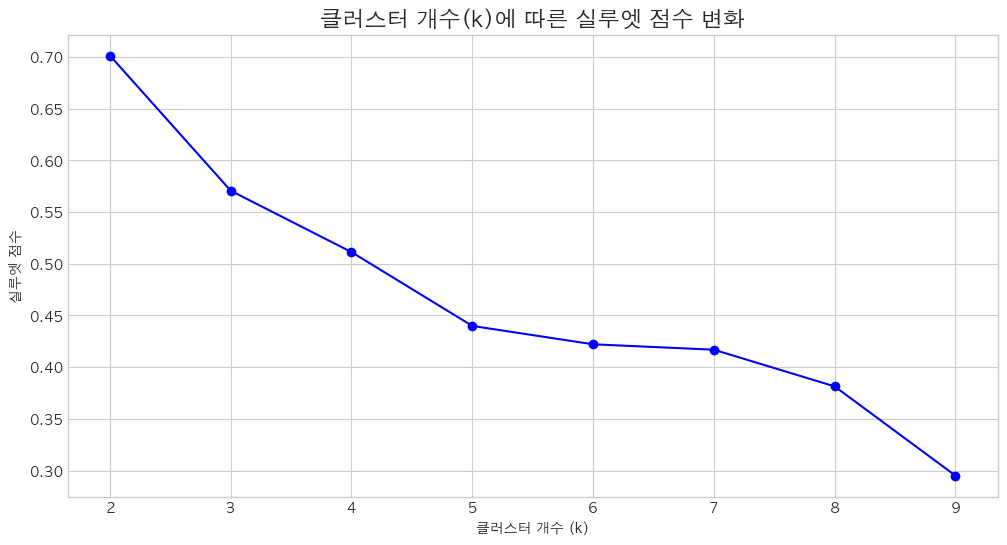


💡 탐색 결과, 최적의 클러스터 개수(k)는 2 입니다.


In [8]:
# -------------------------------------------
# 5. 최적의 클러스터 개수(k) 탐색
# -------------------------------------------
if 'encoder' in locals():
    print("\n🔍 최적의 클러스터 개수(k)를 탐색합니다...")
    features_ae = encoder.predict(x)
    
    silhouette_scores = []
    k_range = range(2, 10)

    for k in k_range:
        agg_clustering = AgglomerativeClustering(n_clusters=k)
        pred = agg_clustering.fit_predict(features_ae)
        score = silhouette_score(features_ae, pred)
        silhouette_scores.append(score)
        print(f'클러스터 개수(k) = {k}, 실루엣 점수: {score:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('클러스터 개수 (k)')
    plt.ylabel('실루엣 점수')
    plt.title('클러스터 개수(k)에 따른 실루엣 점수 변화', fontsize=16)
    plt.grid(True)
    plt.show()

    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f'\n💡 탐색 결과, 최적의 클러스터 개수(k)는 {optimal_k} 입니다.')


[딥러닝 방식] 최종 클러스터링...
[고전 방식] PCA + K-Means 클러스터링...

     딥러닝 Autoencoder 방식 클러스터링 결과
--- 클러스터 0 ---
['Nikkei 225', 'Taiwan', 'S&P 500', 'Dow Jones', 'NASDAQ', 'S&P/TSX', 'FTSE 100', 'DAX', 'CAC 40', 'EURO STOXX 50']

--- 클러스터 1 ---
['KOSPI', 'Shanghai', 'Hang Seng']


     💿 고전 PCA + K-Means 방식 클러스터링 결과
--- 클러스터 0 ---
['Nikkei 225', 'Taiwan', 'S&P 500', 'Dow Jones', 'NASDAQ']

--- 클러스터 1 ---
['KOSPI', 'Shanghai', 'Hang Seng', 'S&P/TSX', 'FTSE 100', 'DAX', 'CAC 40', 'EURO STOXX 50']


     💯 성능 평가 (실루엣 점수) 💯
딥러닝 방식 실루엣 점수: 0.7013
고전 방식(PCA) 실루엣 점수: 0.0914


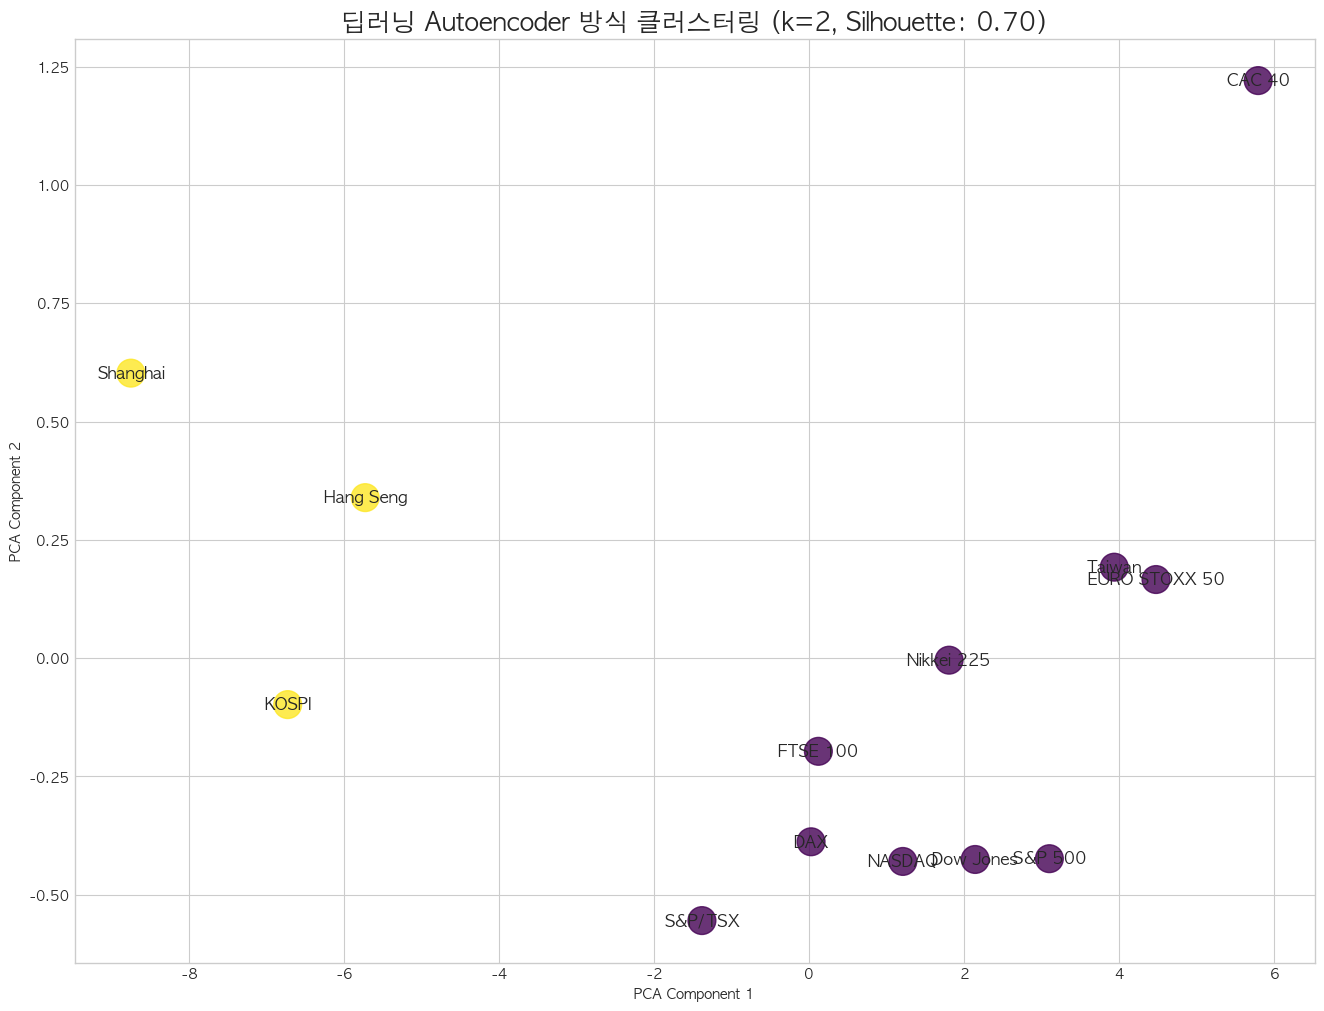

In [9]:
# -------------------------------------------
# 6. 최종 클러스터링 및 결과 비교/시각화
# -------------------------------------------
if 'optimal_k' in locals():
    print("\n[딥러닝 방식] 최종 클러스터링...")
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
    pred_ae = agg_clustering.fit_predict(features_ae)
    cluster_df_ae = pd.DataFrame({'지수명': indices, '클러스터': pred_ae})

    print("[고전 방식] PCA + K-Means 클러스터링...")
    feature_list = [df.values.flatten() for df in trimmed_index_dict.values()]
    X_features = np.array(feature_list)
    pca = PCA(n_components=min(len(indices)-1, 10), random_state=42)
    features_pca = pca.fit_transform(X_features)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    pred_pca = kmeans.fit_predict(features_pca)
    cluster_df_pca = pd.DataFrame({'지수명': indices, '클러스터': pred_pca})

    print("\n" + "="*50)
    print("     딥러닝 Autoencoder 방식 클러스터링 결과")
    print("="*50)
    for i in sorted(cluster_df_ae['클러스터'].unique()):
        cluster_indices = cluster_df_ae[cluster_df_ae['클러스터'] == i]['지수명'].values
        print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

    print("\n" + "="*50)
    print("     💿 고전 PCA + K-Means 방식 클러스터링 결과")
    print("="*50)
    for i in sorted(cluster_df_pca['클러스터'].unique()):
        cluster_indices = cluster_df_pca[cluster_df_pca['클러스터'] == i]['지수명'].values
        print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

    silhouette_ae = silhouette_score(features_ae, pred_ae)
    silhouette_pca = silhouette_score(features_pca, pred_pca)
    print("\n" + "="*50)
    print("     💯 성능 평가 (실루엣 점수) 💯")
    print("="*50)
    print(f"딥러닝 방식 실루엣 점수: {silhouette_ae:.4f}")
    print(f"고전 방식(PCA) 실루엣 점수: {silhouette_pca:.4f}")

    pca_2d = PCA(n_components=2, random_state=42)
    features_ae_2d = pca_2d.fit_transform(features_ae)
    
    plt.figure(figsize=(16, 12))
    plt.title(f'딥러닝 Autoencoder 방식 클러스터링 (k={optimal_k}, Silhouette: {silhouette_ae:.2f})', fontsize=18)
    plt.scatter(features_ae_2d[:, 0], features_ae_2d[:, 1], c=pred_ae, cmap='viridis', s=400, alpha=0.8)
    for i, txt in enumerate(indices):
        plt.annotate(txt, (features_ae_2d[i, 0], features_ae_2d[i, 1]), fontsize=12, ha='center', va='center')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()